In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,\
                            precision_recall_curve, accuracy_score,\
                            recall_score, precision_score, confusion_matrix,\
                            mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold,\
                                    train_test_split, cross_val_score,train_test_split,\
                                    KFold, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier,\
                             BaggingRegressor, BaggingClassifier, RandomForestRegressor,\
                             RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso, LassoCV,\
                                 Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import itertools as it
import time as time
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 

### Distribution of response
*By Jack Troxel*

- Response Mean: 197,845
- Response Standard Deviation: 133,092

<AxesSubplot:xlabel='totalyearlycompensation', ylabel='Density'>

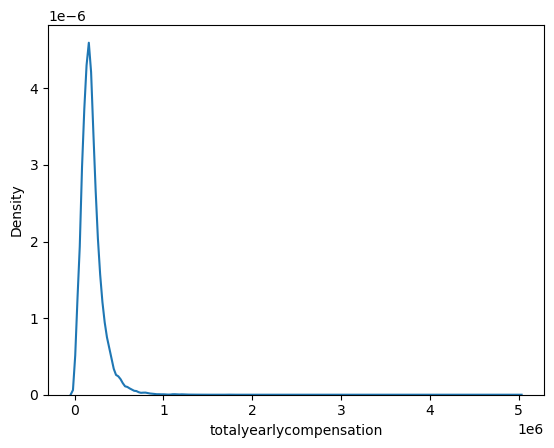

In [3]:
# Plot distribution of response
data = pd.read_csv("data/salary_data_cleaned.csv").drop(columns = "Unnamed: 0")
sns.kdeplot(data=data, x="totalyearlycompensation")

<AxesSubplot:xlabel='totalyearlycompensation', ylabel='Density'>

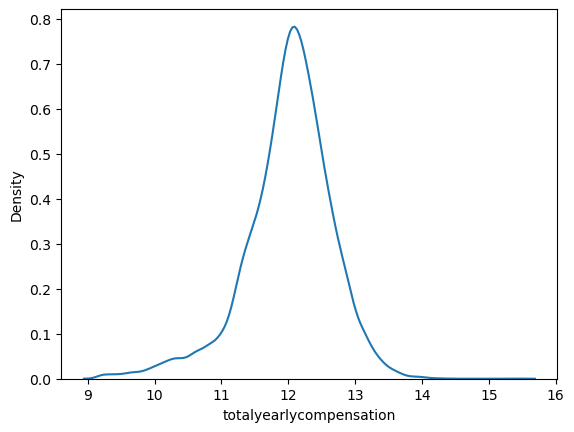

In [4]:
# Plot distribution of transformed response
sns.kdeplot(data=data, x=np.log(data.totalyearlycompensation))

### Data cleaning
*By Lainey Neild and Charlie Lovett*

In [5]:
# Read in original data from Kaggle
data = pd.read_csv('data/salary_data.csv')

# Drop bad predictors and general misc cleaning
data_cleaned = data.drop(columns = ["location", "timestamp", "basesalary", "stockgrantvalue", "otherdetails", "rowNumber", "bonus", "cityid"])
data_cleaned = data_cleaned.loc[data_cleaned.gender.notnull() & data_cleaned.Race.notnull() & data_cleaned.Education.notnull()]
data_cleaned = data_cleaned.drop(columns = ["Race", "Education"]) # already listed as dummy vars
data_cleaned.company = data_cleaned.company.str.lower()
data_cleaned.company = data_cleaned.company.str.replace(" ", "")
data_cleaned.company = data_cleaned.company.str.replace("-", "")
data_cleaned.company = data_cleaned.company.str.replace(",", "")
data_cleaned.company = data_cleaned.company.str.replace(".", "")
data_cleaned['dmaid'] = data_cleaned['dmaid'].astype(str)

### Data preparation
*By Jacob Muriel*

The following data preparation step helped us to prepare our data for implementing various modeling / validation techniques:

- Since we had so many different values for some categorical predictors, we needed to find a way to limit the number that we include so that it would be possible to train our models.

In [6]:
# Rank most frequent categorical predictors
top_cmp_lst = data_cleaned.company.value_counts().index.to_list()[:10]
top_tag_lst = data_cleaned.tag.value_counts().index.to_list()[:10]
top_title_lst = data_cleaned.title.value_counts().index.to_list()[:10]
top_level_lst = data_cleaned.level.value_counts().index.to_list()[:10]
top_dmaid_lst = data_cleaned.dmaid.value_counts().index.to_list()[:46]

# Set up for creation of dummy variables only for most common categorical observations
data_cleaned.company = data_cleaned.company.apply(lambda x: x if x in top_cmp_lst else "other")
data_cleaned.tag = data_cleaned.tag.apply(lambda x: x if x in top_tag_lst else "other")
data_cleaned.title = data_cleaned.title.apply(lambda x: x if x in top_title_lst else "other")
data_cleaned.level = data_cleaned.level.apply(lambda x: x if x in top_level_lst else "other")
data_cleaned.dmaid = data_cleaned.dmaid.apply(lambda x: x if x in top_dmaid_lst else "other")

# Read Data
data_cleaned = pd.get_dummies(data_cleaned)
X = data_cleaned.drop(columns = ['totalyearlycompensation'])
y = data_cleaned.totalyearlycompensation

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [7]:
# Read in final cleaned data set as prepared above
X = pd.read_csv('data/X_train.csv').drop(columns = "Unnamed: 0")
X_test = pd.read_csv('data/X_test.csv').drop(columns = "Unnamed: 0")
y = pd.read_csv('data/y_train.csv').drop(columns = "Unnamed: 0")
y_test = pd.read_csv('data/y_test.csv').drop(columns = "Unnamed: 0")

## Exploratory data analysis
*By Jacob Muriel*

<AxesSubplot:xlabel='yearsatcompany'>

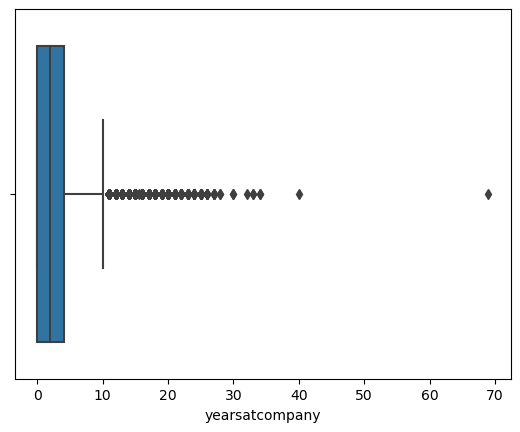

In [24]:
# Visualize distribution of yearsatcompany
sns.boxplot(data=data, x="yearsatcompany")

<AxesSubplot:xlabel='yearsofexperience'>

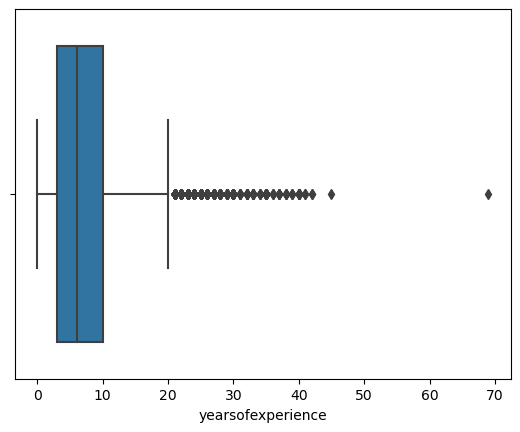

In [25]:
# Visualize distribution of yearsofexperience
sns.boxplot(data=data, x="yearsofexperience")

(0.0, 1000000.0)

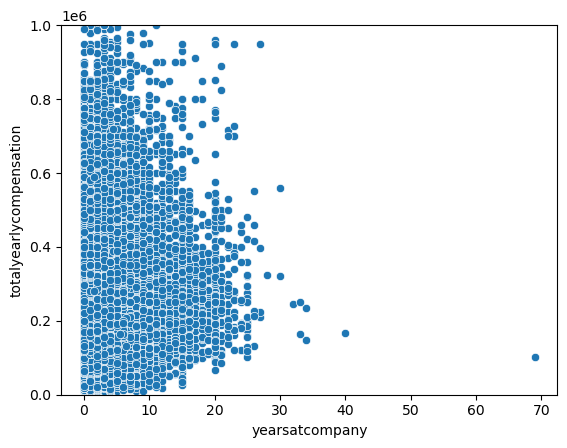

In [26]:
# Visualize relationship between yearsatcompany and response
ax = sns.scatterplot(data=data, x = "yearsatcompany", y = "totalyearlycompensation")
ax.set_ylim(0, 1000000)

(0.0, 1000000.0)

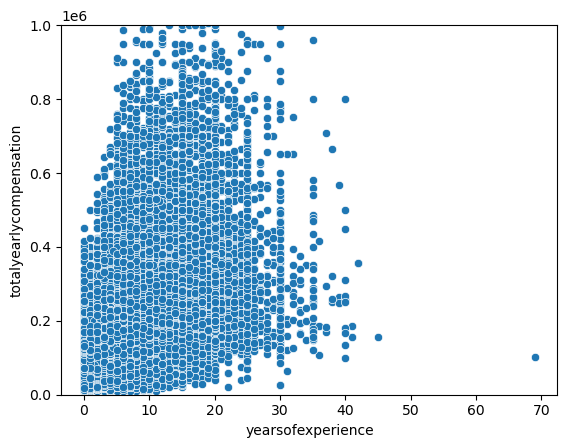

In [27]:
# Visualize relationship between yearsofexperience and response
ax = sns.scatterplot(data=data, x = "yearsofexperience", y = "totalyearlycompensation")
ax.set_ylim(0, 1000000)

## Developing the model: Hyperparameter tuning

### Lasso & Ridge
*By Charlie Lovett*

#### Standardize Data for Lasso and Ridge

In [65]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# Transform y
y_trans = np.log(y).totalyearlycompensation

#### Lasso - Coarse Search

Text(0, 0.5, 'Standardized coefficient')

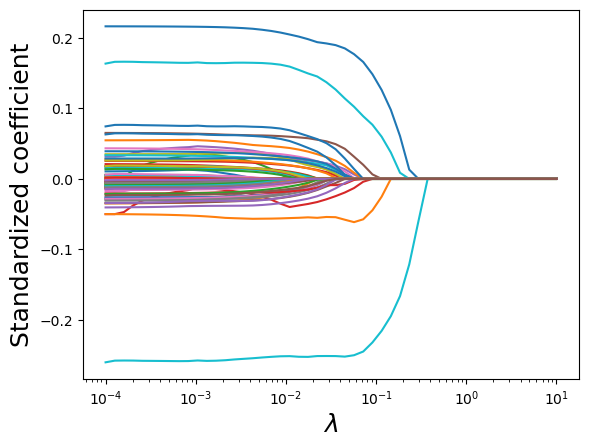

In [67]:
alphas = 10**np.linspace(2,-3,50)*0.1

lasso = Lasso(max_iter = 1000)

coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_std, y_trans)
    coefs.append(lasso.coef_)
    
# Visualization
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [68]:
lassocv = LassoCV(alphas = alphas,
                  cv = 10,
                  max_iter = 100000)
lassocv.fit(X_train_std, y_trans)
print('Coarse Grid Search Alpha:', lassocv.alpha_)

# Compute MAE on Test Data
lasso_model = Lasso(alpha = lassocv.alpha_).fit(X_train_std, y_trans)
print('MAE:', mean_absolute_error(np.exp(lasso_model.predict(X_test_std)), y_test))

Coarse Grid Search Alpha: 0.0005179474679231213
MAE: 55412.6571392422


#### Lasso - Fine Search

In [69]:
alphas = 10**np.linspace(-3,-2,100)

lasso = Lasso(max_iter = 1000)

coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_std, y_trans)
    coefs.append(lasso.coef_)
    
# Fitting and finding optimal alpha
lassocv = LassoCV(alphas = alphas,
                  cv = 10,
                  max_iter = 100000)
lassocv.fit(X_train_std, y_trans)
print('Fine Grid Search Alpha:', lassocv.alpha_)

# Compute MAE on Test Data
lasso_model = Lasso(alpha = lassocv.alpha_).fit(X_train_std, y_trans)
print('Final Lasso MAE:', mean_absolute_error(np.exp(lasso_model.predict(X_test_std)), y_test))

Fine Grid Search Alpha: 0.001
Final Lasso MAE: 55359.46965103638


#### Ridge - Coarse Search

Text(0, 0.5, 'Standardized coefficient')

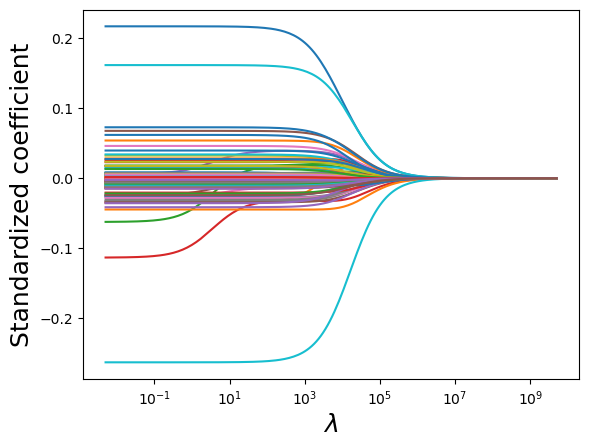

In [71]:
alphas = 10**np.linspace(10,-2,200)*0.5

# Finding Coefficients
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(X_train_std, y_trans)
    coefs.append(ridge.coef_)

# Visualization
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [72]:
ridgecv = RidgeCV(alphas = alphas,
                  scoring = 'neg_mean_squared_error',
                  cv = 10)
ridgecv.fit(X_train_std, y_trans)
print('Coarse Grid Search Alpha:', ridgecv.alpha_)

# Compute MAE on Test Data
ridge_model = Ridge(alpha = ridgecv.alpha_).fit(X_train_std, y_trans)
print('MAE:', mean_absolute_error(np.exp(ridge_model.predict(X_test_std)), y_test))

Coarse Grid Search Alpha: 83.19084430380654
MAE: 55396.47740874736


#### Ridge - Fine Search

In [73]:
alphas = 10**np.linspace(1.7,2.06,200)

# Finding Coefficients
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(X_train_std, y_trans)
    coefs.append(ridge.coef_)

# Fitting and finding optimal alpha
ridgecv = RidgeCV(alphas = alphas,
                  scoring = 'neg_mean_squared_error',
                  cv = 10)
ridgecv.fit(X_train_std, y_trans)
print('Fine Grid Search Alpha:', ridgecv.alpha_)

# Compute MAE on Test Data
ridge_model = Ridge(alpha = ridgecv.alpha_).fit(X_train_std, y_trans)
print('MAE:', mean_absolute_error(np.exp(ridge_model.predict(X_test_std)), y_test))

Fine Grid Search Alpha: 85.06457640936617
MAE: 55394.62930684184


### Random Forest
*By Lainey Neild*

In [18]:
y_log = np.log(y_train)

In [19]:
# naive model
naive_model = RandomForestRegressor(random_state=1).fit(X_train, y_log)

In [20]:
#make preds
naive_pred = naive_model.predict(X_test)
naive_pred_exp = np.exp(naive_pred)
print("naive model MAE:", mean_absolute_error(naive_pred_exp, y_test))

naive model MAE: 50323.32635401146


vizualizing n estimators

In [21]:
oob_rsquared = {}
test_rsquared = {}
oob_mae = {}
test_mae = {}

for i in np.linspace(50, 1000, 100, dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1, max_features="sqrt",
                                   n_jobs=-1, oob_score=True).fit(X_train, y_log)
    oob_rsquared[i] = model.oob_score_
    oob_mae[i] = mean_absolute_error(model.oob_prediction_, y_log)
    pred = model.predict(X_test)
    pred = np.exp(pred)  # Exponentiate predicted values to get back to original scale
    test_rsquared[i] = r2_score(y_test, pred)  # Calculate R-squared on original scale
    test_mae[i] = mean_absolute_error(pred, y_test)  # Calculate MAE on original scale

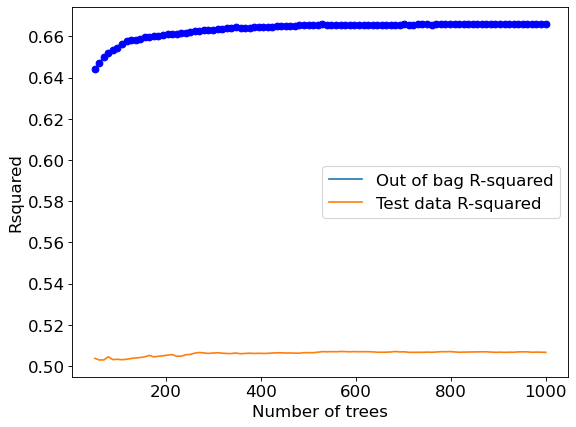

In [22]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

Looks like the test data r-squared stays pretty constant throughout different # of trees and otu of bag r-squared initially increases a bit and then plateus. The max of test data r-squared is between 200 and 400 tree and the oob r-squared plateaus at around 300-350 trees. Therefore, we should use 375 trees to optimize our model. 

In [25]:
param_grid = {'n_estimators': [375],
            'max_depth': [23, 24, 25, 26, 27],
            'max_leaf_nodes':[3000, 3250, 3500], 
            'max_features': [18, 20, 22]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

# setting max depth since not changing much
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1), 
                            param_grid=param_grid, verbose=1, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
optimal_params = grid_search.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Optimal parameter values = {'max_depth': 26, 'max_features': 20, 'max_leaf_nodes': 3000, 'n_estimators': 375}
Optimal cross validation R-squared =  -49256.496023678876


In [26]:
param_grid = {'n_estimators': [375],
            'max_depth': [25, 26, 27, 28, 29],
            'max_leaf_nodes':[32500, 3500, 3750], 
            'max_features': [18, 20, 22]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

# setting max depth since not changing much
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1), 
                            param_grid=param_grid, verbose=1, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
optimal_params = grid_search.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Optimal parameter values = {'max_depth': 26, 'max_features': 20, 'max_leaf_nodes': 3500, 'n_estimators': 375}
Optimal cross validation R-squared =  -49278.601655086284


In [29]:
#Model with optimal parameters
random_forest_model = RandomForestRegressor(n_estimators=375, random_state=1,max_leaf_nodes=3500,max_depth=26,
                        oob_score=True,n_jobs=-1, max_features=20).fit(X_train, y_log)

#make preds
pred = random_forest_model.predict(X_test)
pred_exp = np.exp(pred)
print("final model MAE:", mean_absolute_error(pred_exp, y_test))

final model MAE: 48583.98353327673


### AdaBoost
*By Jacob Muriel*

In [5]:
start_time = time.time()
model = AdaBoostRegressor(random_state=1, n_estimators=200)
grid = dict()
grid['learning_rate'] = [0.005, 0.0075, 0.01, 0.0125, 0.015]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=14), DecisionTreeRegressor(max_depth=18), DecisionTreeRegressor(max_depth=20)]
cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
grid_result = grid_search.fit(X_train, y)
print((grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("Time taken = ",(time.time()-start_time)/60," minutes")

/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when 

/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when 

/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacobmuriel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when 

(-50535.20747012748, {'base_estimator': DecisionTreeRegressor(max_depth=18), 'learning_rate': 0.005})
Time taken =  6.214318815867106  minutes


In [19]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=18),n_estimators=200,learning_rate=0.0125,
                         random_state=1).fit(X,y)
print("AdaBoost model MAE = ", (mean_absolute_error(model.predict(X_test),y_test)))

AdaBoost model MAE =  51219.42073530099


In [20]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=18),n_estimators=200,learning_rate=0.005,
                         random_state=1).fit(X,y)
print("AdaBoost model MAE = ", (mean_absolute_error(model.predict(X_test),y_test)))

AdaBoost model MAE =  50903.72070721853


### Gradient Boosting & XGBoost
*By Jack Troxel*

#### Tuning Gradient Boosting

In [35]:
# Transform response
y = np.log(y)

>2 0.052 (0.001)
>5 0.047 (0.001)
>10 0.042 (0.001)
>50 0.035 (0.001)
>100 0.033 (0.001)
>500 0.032 (0.001)
>1000 0.032 (0.001)
>2000 0.032 (0.001)
>5000 0.032 (0.001)


Text(0.5, 0, 'Number of trees')

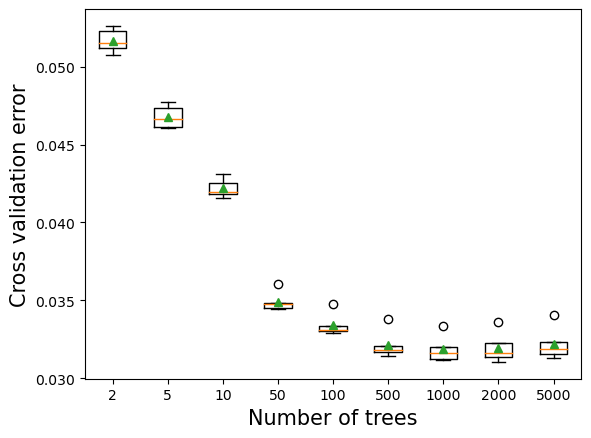

In [28]:
# Visualize number of trees vs. CV MAE

def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [2, 5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n,random_state=1,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, np.squeeze(y))
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.040 (0.001)
>2 0.037 (0.001)
>3 0.035 (0.001)
>4 0.034 (0.001)
>5 0.033 (0.001)
>6 0.033 (0.001)
>7 0.032 (0.001)
>8 0.032 (0.001)
>9 0.032 (0.001)
>10 0.032 (0.001)
>11 0.032 (0.001)
>12 0.033 (0.001)
>13 0.033 (0.001)
>14 0.033 (0.001)
>15 0.034 (0.001)
>16 0.034 (0.001)
>17 0.035 (0.001)
>18 0.035 (0.001)
>19 0.036 (0.001)
>20 0.036 (0.001)


Text(0.5, 0, 'Depth of each tree')

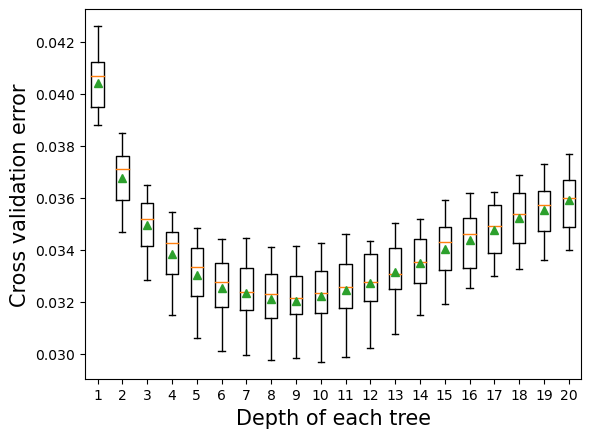

In [30]:
# Visualize depth of tree vs. CV MAE

# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = GradientBoostingRegressor(n_estimators=50,random_state=1,max_depth=i,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, np.squeeze(y))
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.1 0.0 (0.0)
>0.2 0.0 (0.0)
>0.3 0.0 (0.0)
>0.4 0.0 (0.0)
>0.5 0.0 (0.0)
>0.6 0.0 (0.0)
>0.7 0.0 (0.0)
>0.8 0.0 (0.0)
>0.9 0.0 (0.0)
>1.0 0.0 (0.0)
>1.1 0.0 (0.0)
>1.2 0.0 (0.0)
>1.3 0.0 (0.0)
>1.4 0.0 (0.0)
>1.5 0.0 (0.0)
>1.6 0.0 (0.0)
>1.7 0.0 (0.0)
>1.8 0.0 (0.0)
>1.9 0.0 (0.0)
>2.0 0.1 (0.0)


Text(0.5, 0, 'Learning rate')

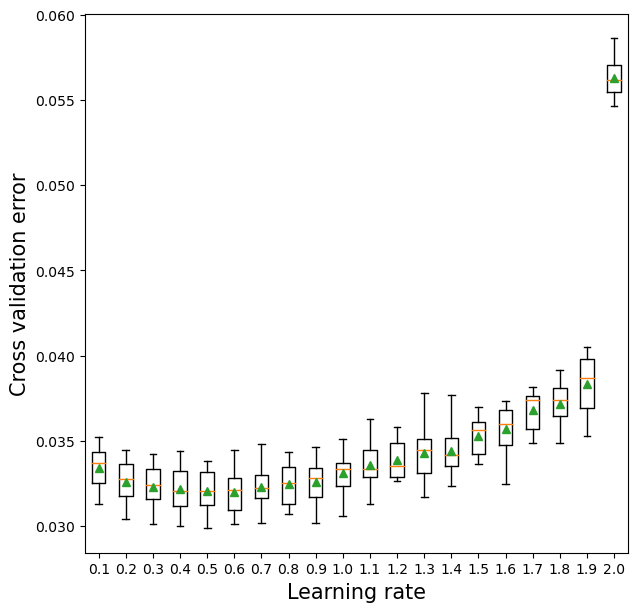

In [31]:
# Visualize learning rate vs. CV MAE

def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingRegressor(learning_rate=i,random_state=1,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, np.squeeze(y))
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.25 0.03 (0.00)
>0.50 0.03 (0.00)
>0.75 0.03 (0.00)
>1.00 0.03 (0.00)


Text(0.5, 0, 'Subsample')

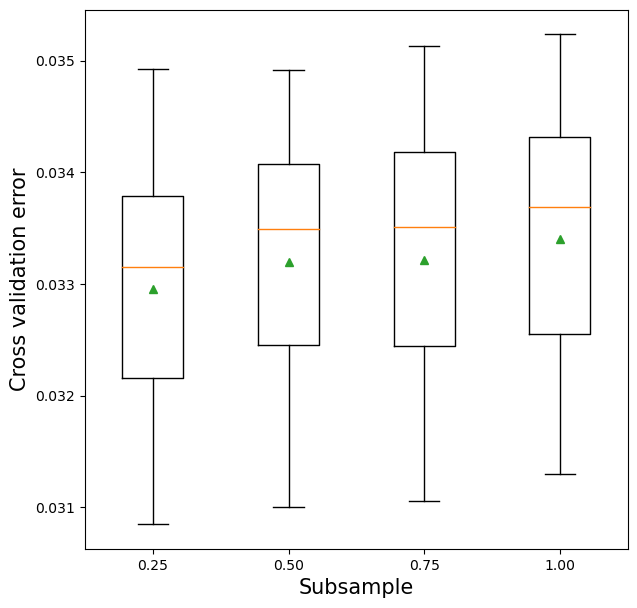

In [32]:
# Visualize subsample vs. CV MAE

def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for s in np.arange(0.25, 1.1, 0.25):
        key = '%.2f' % s
        models[key] = GradientBoostingRegressor(random_state=1,subsample=s,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, np.squeeze(y))
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.2f (%.2f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Subsample',fontsize=15)

In [33]:
# Final fine grid search for Gradient Boosting

start_time = time.time()
model = GradientBoostingRegressor(random_state=1,loss='huber')
grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [5,6,7,8,9,10,11,12]
grid['subsample'] = [0.25, 0.5, 0.75, 1]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error',
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X, np.squeeze(y))
# summarize the best score and configuration
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best: 0.148397 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.75}
Time taken =  42.82890911499659  minutes


In [37]:
#Model based on the optimal parameters
model = GradientBoostingRegressor(max_depth=6,n_estimators=450,learning_rate=0.1, subsample=0.75,
                         random_state=1,loss='huber').fit(X,np.squeeze(y))

*Best MAE on test data from Gradient Boosting: 47,579*

#### Tuning XGBoost

In [17]:
# Transform response
y = np.log(y)

>5 1.392 (0.002)
>10 0.642 (0.002)
>50 0.517 (0.006)
>100 0.517 (0.007)
>500 0.530 (0.007)
>1000 0.541 (0.006)
>2000 0.554 (0.005)
>5000 0.569 (0.005)


Text(0.5, 0, 'Number of trees')

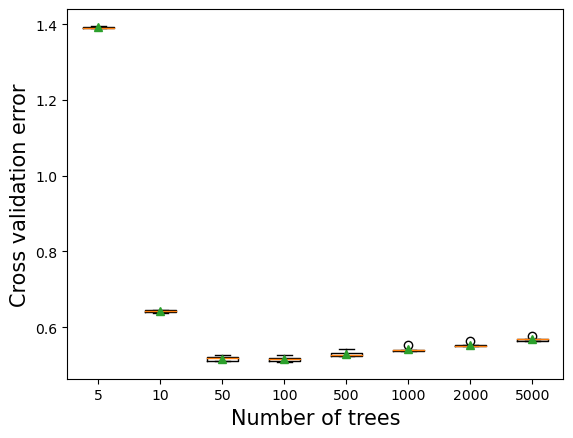

In [18]:
# Visualize number of trees vs. CV MAE

def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.544 (0.008)
>2 0.525 (0.008)
>3 0.519 (0.009)
>4 0.515 (0.009)
>5 0.513 (0.010)
>6 0.513 (0.009)
>7 0.515 (0.007)
>8 0.517 (0.010)
>9 0.520 (0.008)
>10 0.523 (0.009)
>11 0.525 (0.008)
>12 0.526 (0.009)
>13 0.531 (0.007)
>14 0.535 (0.010)
>15 0.536 (0.008)
>16 0.537 (0.009)
>17 0.539 (0.008)
>18 0.538 (0.006)
>19 0.542 (0.007)
>20 0.542 (0.008)


Text(0.5, 0, 'Depth of each tree')

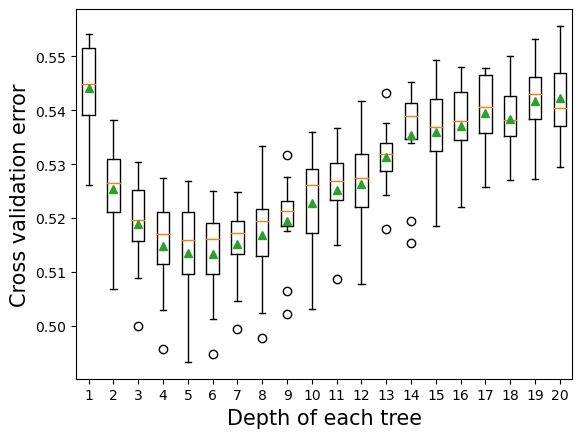

In [19]:
# Visualize depth of tree vs. CV MAE

def get_models():
    models = dict()
    # explore depths from 1 to 20
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.1000 0.5 (0.0)
>0.2000 0.5 (0.0)
>0.3000 0.5 (0.0)
>0.4000 0.5 (0.0)
>0.5000 0.5 (0.0)
>0.6000 0.5 (0.0)
>0.8000 0.5 (0.0)
>1.0000 0.6 (0.0)


Text(0.5, 0, 'Learning rate')

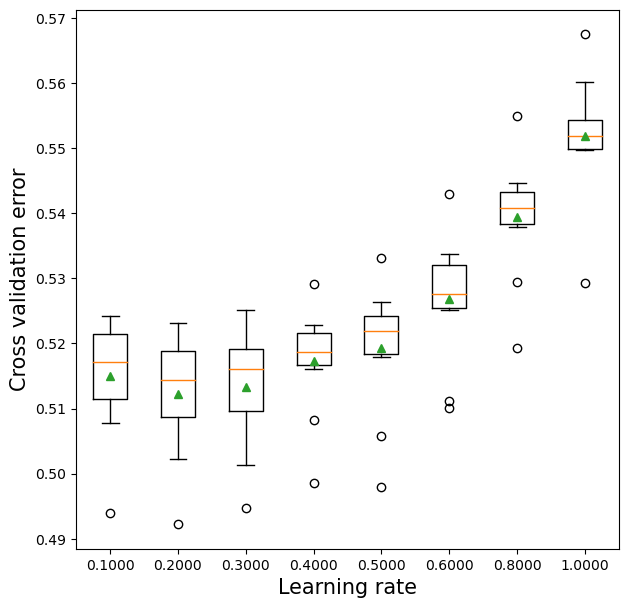

In [20]:
# Visualize learning rate vs. CV MAE

def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0000 0.5 (0.0)
>0.5000 0.5 (0.0)
>1.0000 0.5 (0.0)
>1.5000 0.5 (0.0)
>2.0000 0.5 (0.0)
>10.0000 0.5 (0.0)
>100.0000 0.5 (0.0)


Text(0.5, 0, 'reg_lambda')

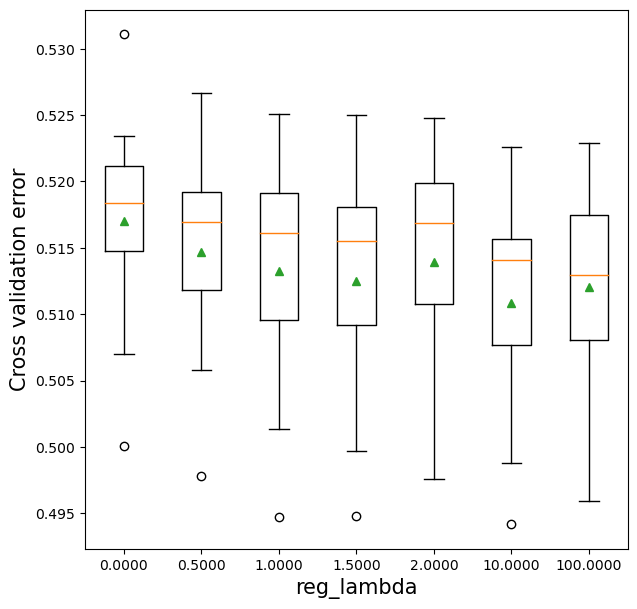

In [21]:
# Visualize reg lambda vs. CV MAE

def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

>0.0000 0.5 (0.0)
>10.0000 0.5 (0.0)
>100.0000 0.6 (0.0)
>1000.0000 0.7 (0.0)
>10000.0000 0.7 (0.0)
>100000.0000 0.7 (0.0)
>1000000.0000 0.7 (0.0)
>10000000.0000 0.7 (0.0)
>100000000.0000 0.7 (0.0)
>1000000000.0000 0.7 (0.0)


Text(0.5, 0, 'gamma')

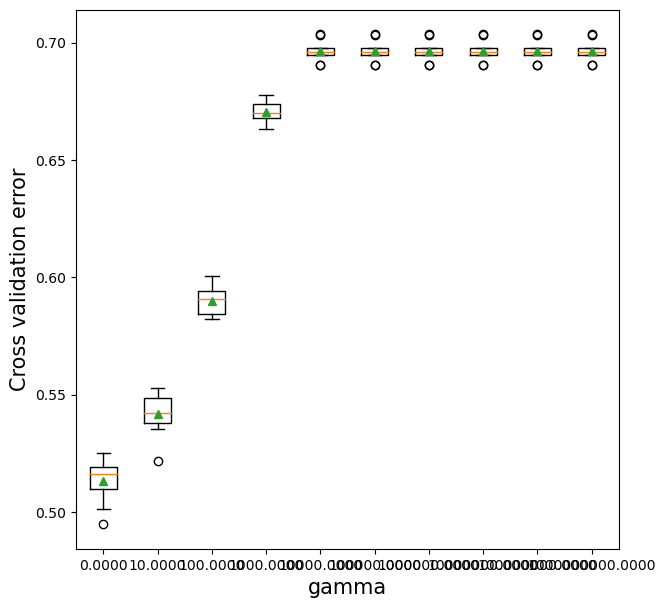

In [22]:
# Visualize Gamma vs. CV MAE

def get_models():
    models = dict()
    # explore gamma from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

In [23]:
#Coarse Tuning with Grid Search
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [4,5,6,7],
              'learning_rate': [0.1,0.2,0.3],
               'reg_lambda':[2, 10],
                'n_estimators':[200],
                'gamma': [0, 10],
                'subsample': [0.3,0.4,0.5]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 2 folds for each of 144 candidates, totalling 288 fits
Optimal parameter values = {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.5}
Optimal cross validation R-squared =  0.6839140269457644
Time taken =  5.651215402285258  minutes


In [24]:
#Further Coarse Tuning
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [5,6],
              'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
               'reg_lambda':[10],
                'n_estimators':[200],
                'gamma': [0],
                'subsample': [0.35, 0.4, 0.45]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Optimal parameter values = {'gamma': 0, 'learning_rate': 0.11, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.45}
Optimal cross validation R-squared =  0.6847940580142464
Time taken =  1.173985497156779  minutes


In [25]:
#Final Round of Tuning
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [5,6],
              'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
               'reg_lambda':[1,10],
                'n_estimators':[200],
                'gamma': [0,10],
                'subsample': [0.35, 0.4, 0.45]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Optimal parameter values = {'gamma': 0, 'learning_rate': 0.08, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.35}
Optimal cross validation R-squared =  0.6917219858106866
Time taken =  9.365643215179443  minutes


In [26]:
# Best MAE on Test Data
model = xgb.XGBRegressor(random_state = 1, max_depth = 6, learning_rate = 0.08,
                        n_estimators = 450,reg_lambda = 10, gamma = 0, subsample = 0.75).fit(X,y)
print("MAE on test data:",mean_absolute_error(np.exp(model.predict(X_test)),y_test))

MAE on test data: 47440.01453503097


*Best MAE on test data from XGBoost: 47,440*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

- Final Model MAE: 47,082
- MAE of intercept only model: 87,176

This final model MAE may not initially seem impressive, but comparing it to the MAE of an intercept only model gives more context. Many people compare salaries based on the "averages" in certain industries, but clearly in this case, our model is significantly more accurate at predicting STEM salaries than predicting based off of the average. Employers can use this model to more accurately price their compensation packages based on industry trends. Students (and employees in general) can use this model to make more accurate predictions of their salaries in a STEM job.
